In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout


# === 데이터 불러오기 및 통합 === 
weather2017 = pd.read_csv('data/weather/weather2017.csv', encoding='cp949')
weather2018 = pd.read_csv('data/weather/weather2018.csv', encoding='cp949')
weather2019 = pd.read_csv('data/weather/weather2019.csv', encoding='cp949')
weather2020 = pd.read_csv('data/weather/weather2020.csv', encoding='cp949')
weather2021 = pd.read_csv('data/weather/weather2021.csv', encoding='cp949')
weather2022 = pd.read_csv('data/weather/weather2022.csv', encoding='cp949')


#print(weather.shape) ==> (52563, 38)
nsv = pd.read_csv('data/nsv/jeonnam.csv', encoding='cp949')
# print(nsv.shape) ==> (191003, 17)

# === 날씨 데이터 전처리 ===
weather = pd.concat([weather2017, weather2018, weather2019, weather2020, weather2021, weather2022])
# 1. NaN 개수 확인하기
# print(weather.isnull().sum()) # ==> 지울 것들 : 기온 QC플래그, 강수량 (mm), 강수량 QC플래그, 풍속 QC플래그, 풍향 QC플래그, 습도 QC플래그, 현지기압 QC플래그, 해면기압 QC플래그, 일조 (hr), 일조 QC플래그, 일사(MJ/m2), 일사 QC플래그, 적설 (cm), 3시간신적설 (cm), 운형(운형약어), 최저운고 (100m ), 지면상태(지면상태코드), 현상번호(국내식), 지면온도 QC플래그
weather = weather.drop(['기온 QC플래그','강수량(mm)','전운량(10분위)','중하층운량(10분위)','강수량 QC플래그','풍속 QC플래그','풍향 QC플래그','습도 QC플래그','현지기압 QC플래그','해면기압 QC플래그','일조(hr)','일조 QC플래그','일사(MJ/m2)','일사 QC플래그','적설(cm)','3시간신적설(cm)','운형(운형약어)','최저운고(100m )','지면상태(지면상태코드)','현상번호(국내식)','지면온도 QC플래그'], axis=1)
#print(nsv.isnull().sum())
#print(weather.isnull().sum())

# 2. 결측값 채우기(NaN => 이전값 대치)
weather = weather.fillna(method='ffill')
#print(weather.isnull().sum())

# 3. 불필요한 변수 제거
weather = weather.drop(['지점','지점명'],axis=1)
nsv = nsv.drop(['id','device_id','data_type','CDMA_tel','InteTemp','ElecTemp','ip_addr','DoseRate_uR','DoseRate_low','DoseRate_high','InteTemp_high','ElecTemp_high','state','DoseRate_warn','DoseRate_alert'],axis=1)

# 4. 날짜 포맷 맞추기
weather['time'] = pd.to_datetime(weather['일시'])
nsv['time'] = pd.to_datetime(nsv['rcv_time'])
weather = weather.drop(['일시'], axis=1)
nsv = nsv.drop(['rcv_time'], axis=1)
# 5. 데이터 통합
df = pd.merge(weather, nsv, on='time', how='inner')

# 6. 기타
df = df.rename(columns={'DoseRate_nSv': 'nsv'})
order = ['time','기온(°C)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)',
       '현지기압(hPa)', '해면기압(hPa)', '시정(10m)', '지면온도(°C)', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)','nsv']
df = df[order]

# df.to_csv('data//mergeData.csv')

# === 상관계수 파악 ===
# 다중공선성 문제를 일으키는 변수 제거
# 꼭 필요한 변수는 성능이 안좋더라도 사용하기로 결정
df = df.drop(['해면기압(hPa)','5cm 지중온도(°C)','10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],axis=1)

# === Random Forest로 중요도 확인 후 상위 5개만 사용 ===
df = df.drop(['증기압(hPa)','풍향(16방위)','이슬점온도(°C)','습도(%)'], axis=1)

2023-10-23 14:23:38.559926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Define a specific window for training Neural Network
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

TRAIN_SPLIT = 30000  # About 2083 days
tf.random.set_seed(13)

# Extract temperature (degree) data & Make univariate series
uni_data = df['nsv']
uni_data.index = df['time']

# Standardization
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std  # Standardization

univariate_past_history = 20
univariate_future_target = 0

# Use the univariate_data function
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print('Single window of past history')
print(x_train_uni[0])
print('\nTarget temperature to predict')
print(y_train_uni[0])


Single window of past history
[[-0.17457537]
 [-0.87143959]
 [ 0.04548701]
 [-0.76691185]
 [-0.98329899]
 [ 0.30230185]
 [-0.19291391]
 [-0.63303868]
 [ 0.44893472]
 [ 0.22879694]
 [-0.88610288]
 [-0.55968455]
 [-0.87511484]
 [-0.58535472]
 [-0.39463776]
 [-0.89160633]
 [-0.50099371]
 [-0.65870885]
 [-0.11955978]
 [-1.90022559]]

Target temperature to predict
-0.1012212445397333


In [12]:
# Defind function for Visualization
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

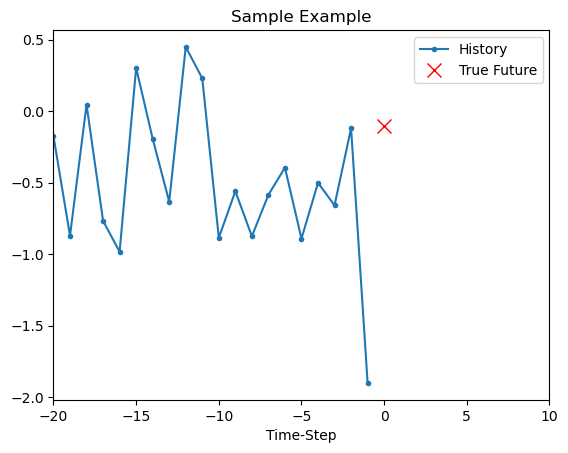

In [13]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()

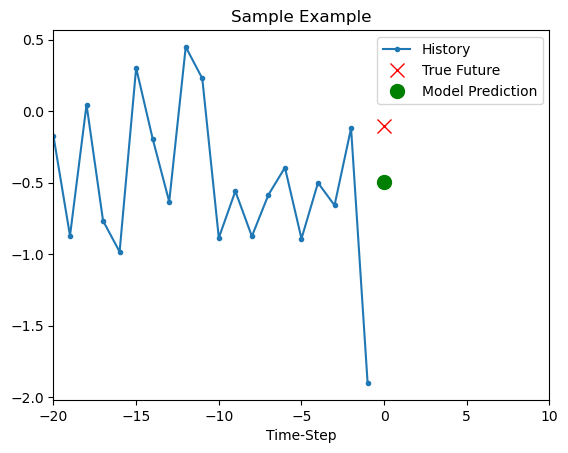

In [14]:
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample Example').show()

In [15]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

np.array(x_train_uni).shape[-2:]

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=np.array(x_train_uni).shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

2023-10-23 14:30:54.914242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4900 - val_loss: 0.4941
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.4902 - val_loss: 0.4948
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4906 - val_loss: 0.4940
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4900 - val_loss: 0.4943
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4902 - val_loss: 0.4939
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4908 - val_loss: 0.4948
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4891 - val_loss: 0.4940
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4908 - val_loss: 0.4942
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4898 - val_loss: 0.4944
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4902 - val_loss: 0.4944

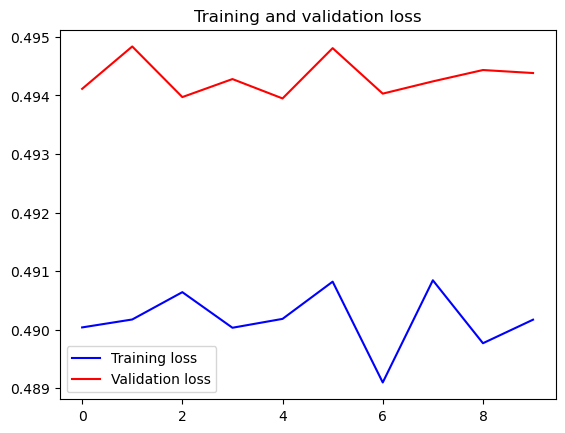

In [21]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

8/8 [==============================] - 0s 2ms/step


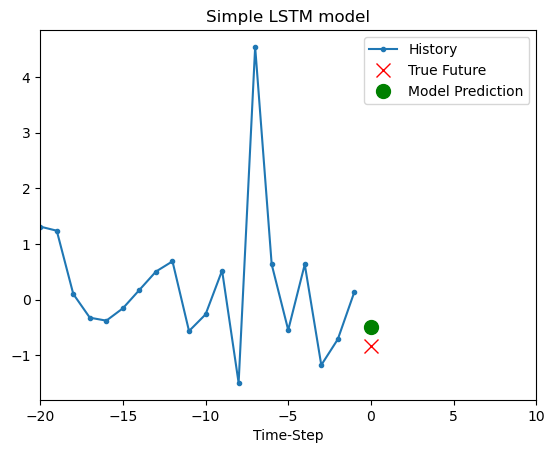

8/8 [==============================] - 0s 2ms/step


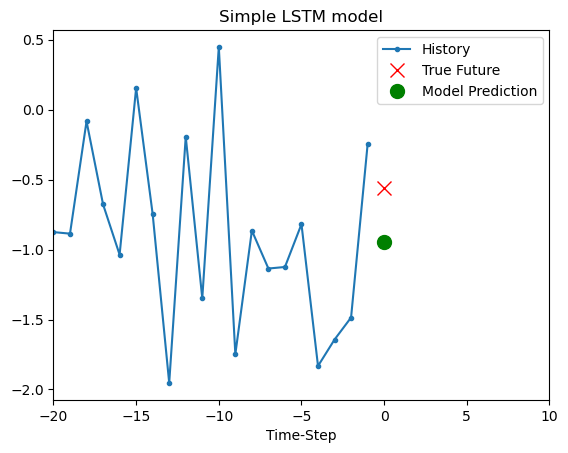

8/8 [==============================] - 0s 2ms/step


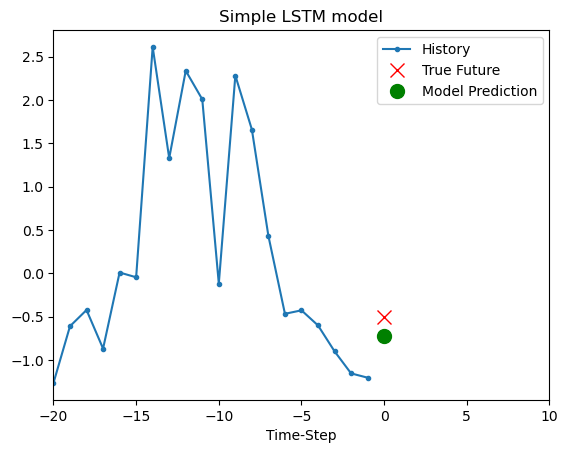

8/8 [==============================] - 0s 2ms/step


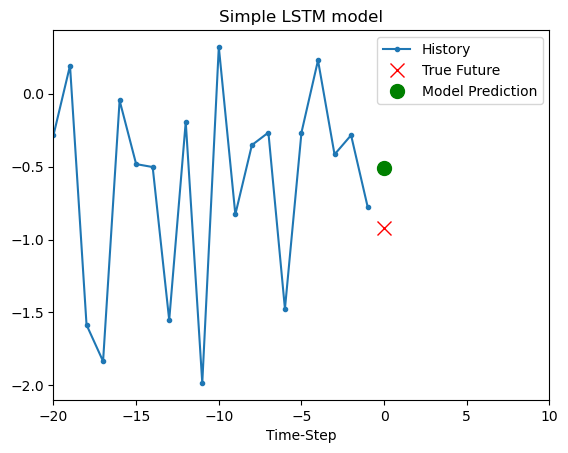

8/8 [==============================] - 0s 2ms/step


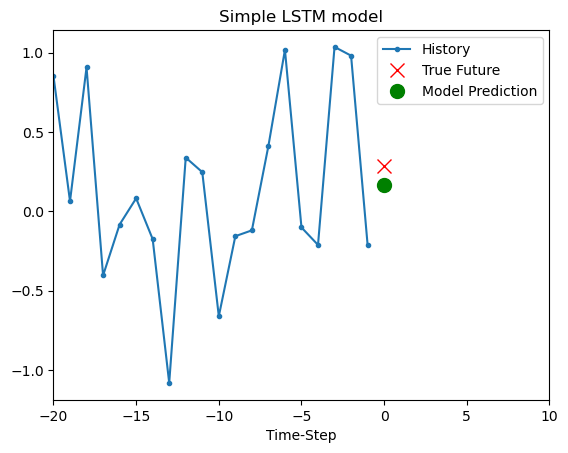

8/8 [==============================] - 0s 2ms/step


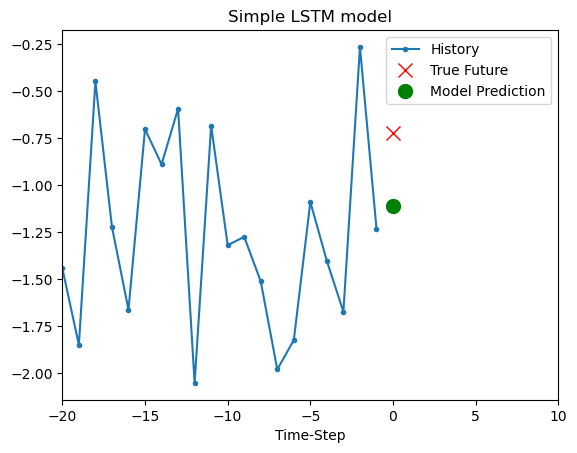

8/8 [==============================] - 0s 2ms/step


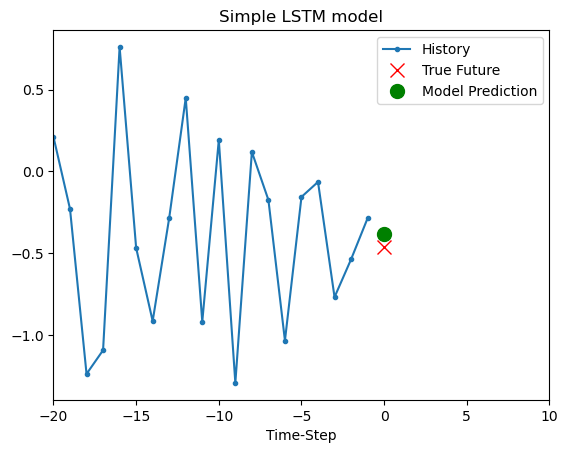

In [22]:
# Make forecasts & Visualize

for x, y in val_univariate.take(7):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [23]:
df.columns

Index(['time', '기온(°C)', '풍속(m/s)', '현지기압(hPa)', '시정(10m)', '지면온도(°C)', 'nsv'], dtype='object')

In [24]:

features_considered = ['기온(°C)', '풍속(m/s)', '현지기압(hPa)','시정(10m)','지면온도(°C)','nsv']
features = df[features_considered]
features.index = df['time']
features.head()

,기온(°C),풍속(m/s),현지기압(hPa),시정(10m),지면온도(°C),nsv
time,,,,,,
2017-01-01 01:00:00,-2.3,0.1,1025.5,557.0,-1.1,97.8838
2017-01-01 02:00:00,-1.6,0.4,1025.7,438.0,-1.0,94.1864
2017-01-01 03:00:00,-0.8,1.1,1025.1,452.0,-0.9,99.0514
2017-01-01 04:00:00,-2.2,0.4,1024.7,337.0,-1.2,94.7410
2017-01-01 05:00:00,-1.0,0.2,1024.8,342.0,-1.0,93.5929


In [26]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
print(dataset)

[[-1.49007247 -1.12320372  1.57296605 -0.93398587 -1.32834371 -0.17457537]
 [-1.42337061 -0.94256884  1.59686804 -1.03961176 -1.32059062 -0.87143959]
 [-1.34713992 -0.52108746  1.52516207 -1.02718519 -1.31283753  0.04548701]
 ...
 [-0.80399623  1.46589618  0.86785735  2.53657931 -0.35145412 -0.22959097]
 [-0.69917903  0.8035683   0.85590636  4.03575695 -0.30493557 -0.77974693]
 [-0.72776554  0.56272179  0.84395536  3.25998356 -0.7546149  -0.22959097]]


In [27]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history,
                                                   future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history,
                                               future_target, STEP, single_step=True)

print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 6)


8/8 [==============================] - 0s 9ms/step
(256, 1)
Epoch 1/10
200/200 [==============================] - 15s 66ms/step - loss: 0.7846 - val_loss: 0.6353
Epoch 2/10
200/200 [==============================] - 13s 65ms/step - loss: 0.7636 - val_loss: 0.6436
Epoch 3/10
200/200 [==============================] - 13s 64ms/step - loss: 0.7382 - val_loss: 0.6709
Epoch 4/10
200/200 [==============================] - 13s 63ms/step - loss: 0.7166 - val_loss: 0.6667
Epoch 5/10
200/200 [==============================] - 13s 63ms/step - loss: 0.7183 - val_loss: 0.6731
Epoch 6/10
200/200 [==============================] - 13s 64ms/step - loss: 0.7076 - val_loss: 0.7027
Epoch 7/10
200/200 [==============================] - 13s 63ms/step - loss: 0.6948 - val_loss: 0.6897
Epoch 8/10
200/200 [==============================] - 13s 63ms/step - loss: 0.6868 - val_loss: 0.6828
Epoch 9/10
200/200 [==============================] - 13s 63ms/step - loss: 0.6856 - val_loss: 0.6889
Epoch 10/10
200/200 [=

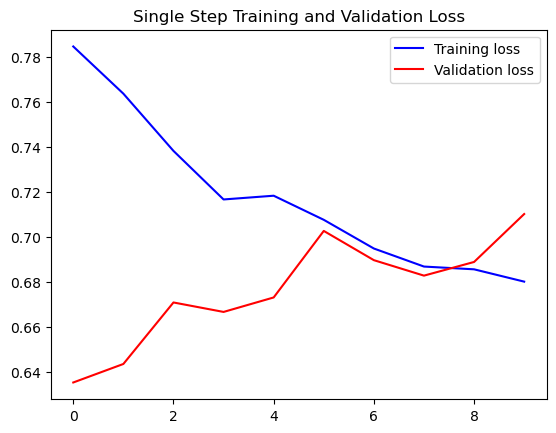

In [28]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)


def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and Validation Loss')

8/8 [==============================] - 0s 10ms/step


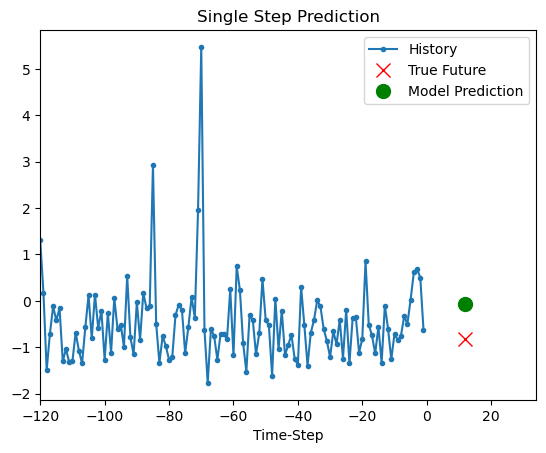

8/8 [==============================] - 0s 10ms/step


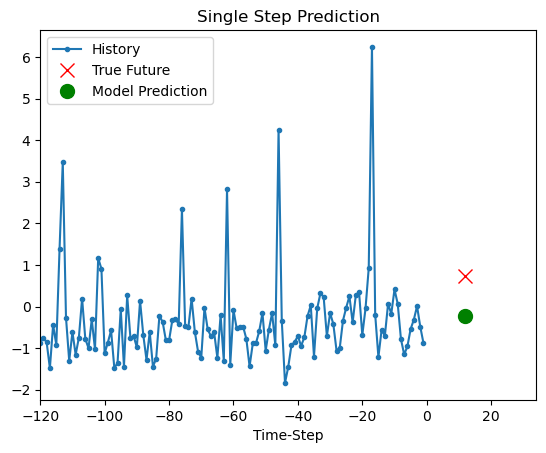

8/8 [==============================] - 0s 10ms/step


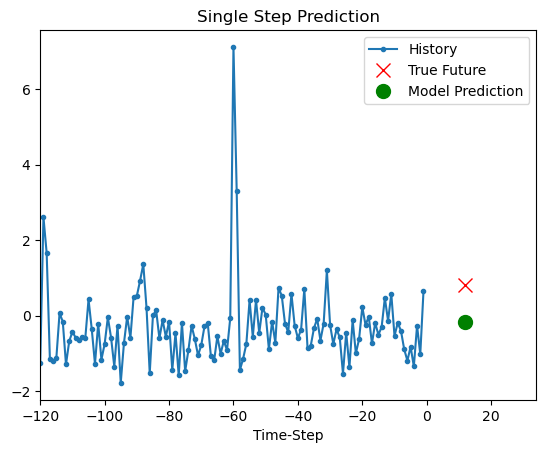

In [33]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 5].numpy(), y[0].numpy(),
                      single_step_model.predict(x)[0]], 12,
                     'Single Step Prediction')
    plot.show()

In [34]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 5], 0,
                                                 TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 5],
                                             TRAIN_SPLIT, None, past_history, future_target, STEP)

print('Single window of past history : {}'.format(x_train_multi[5].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[5].shape))

Single window of past history : (120, 6)

 Target temperature to predict : (72,)
